In [1]:
using DrWatson
@quickactivate "BNP2"
using Turing
using StatsPlots: StatsPlots
const splot = StatsPlots.plot
using Revise, BNP2

┌ Info: Precompiling BNP2 [11504357-4fe5-5405-981c-8cd43ea31635]
└ @ Base loading.jl:1273


In [2]:
args = (
    dt        = 0.1,
    dt_fine   = 0.05,
    alg       = NUTS(50, 0.65),
    n_samples = 100,
)

;

In [3]:
function add_gaussiannoise(states, sigma)
    return sigma .* randn.(size.(states))
end

data =
let obj0 = Particle(1.0, [0.0, 0.0], [10.0, 20.0]), σ = 0.1, T = 20
    env = WithStatic(Space(obj0), EARTH)
    traj = simulate(env, PymunkSimulator(args.dt), 2T)
    HTML(animof([env, traj...]; do_tracklocal=false).to_html5_video()) |> display
    traj = traj[1:T]
    states = add_gaussiannoise(vec.(stateof.(traj)), σ)
    (obj0 = obj0, traj = traj, states = states)
end

;

HTML{String}("<video width=\"500\" height=\"500\" controls autoplay loop>\n  <source type=\"video/mp4\" src=\"data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAAgDm1kYXQAAAKhBgX//53cRem9\n5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENv\ncHlsZWZ0IDIwMDMtMjAxNyAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9w\ndGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1o\nZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2\nIGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0\nX3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE2IGxvb2thaGVhZF90aHJlYWRz\nPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9j\nb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0\nPTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWlu\ndD0yNTAga2V5aW50X21pbj0yMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2Fo\nZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9\nNjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAADq9liIQAO//+906/AptFl2oD\nklcK9sqkJlm5UmsB8qYAAAMAAAMABMhfhdYZyUpNhAAAHeAB6sP8neU+Z+ACZZ/9+FGH9lN20iM8\n/Vgn25oD5DKMuxgrAwPkr9SJyKix1sN8/ry5XoIIo92lBXjX/uxvsoKbQZ0vZQbFVD351k74wY8i\ndYGobA+++4VLR77ougtVkLckcwfzFCYqnRVBGHvbUVW6IzRXUsJb/3h48GUZmfmQ0qzvK80DkAJ/\nYdBiBDz9JUeJJZ+iX0U6Knv5mMMbqNdElDYR/5zyTYIBenMSSk3ZiGSzrfiGybRmLsFfgJ7/IfoE\nWvH7kjke+wpjT4AeB99AZ/v1Y0SbiaPArE04BJVb8HMhMLQqLvUT2GNj33RkT6gG16ev3DX9Tj9O\n5ydIjPjK9Yol1BwHs2d69nQtUGrDyfdJxRrmAJ18vNycwGNMJJW1OG9ZPdZ5p2h3UCgFHvg3L8ab\nztPqdHb8Tg9bar5DFjZjnkbzS48LSPwAAAoMWtMRRxhhuyVgxVL/45C9MEFQl93hAbSd8t1hQSvS\n3kU1B/FJPdFBL66FqnGQf8VOxgfqVYyr7pNoqT2lL3u/+ppJsIlPCG9yIANtmfNSZRA3V/efJHxh\ndW/k1e9B77QMW34n3rsYu9JIOM7lPtdfQh8ge+cr+azqUStxF+69z9DlJwQ7H2ZlQGGND3LQa4Mu\ncgNxzQp2xQqNNpAWA3KKEUCRmQ51v0GS85oEX6CA2tvcsAFMP9OWVWcRhhDqmZBe24F3KuMxD/R/\nH5ijHQfwtRNgSrVJc/aZ+ZkYhAh0wkliAJ3BYCrOG10O134i+3kkUe5pWG3sM82BWUqs7NF7gIBf\nzQnZtuTACBoQfu4duwVYNbWy9JPknSncjUJIA33XlU8m/+MB4LsAAAMCimEkNr+L3v8eor0SGoLd\nsW6acF2gBGvlYLFts/IUVJ8OBnfXNxUzigOpM3CGwLyZ6rpo3N1n3DwtNCDP3UjPbU+eO5pD44Jf\n4Mfyg9v58xPCMAgJUNOj4DTGEEkud5/aHQ1rb6Op6ge+Rbdvb6Qr8eS8oPpZ4P/qDMwcuQ1x6PPm\nS8aDE2SMabPmPdOJ1EkMNaBzl6hb2lvNYdP7+lo9dK0ZAqnGP5UMOWFM6Kxg1ym7iz+b30oHO8Ul\n+HGV2AlIBdu7gvBp5vbeVl9HJAV7NvcgHksMseTlNLvddv/6RWH7916RAzRlj17yJ0IaDK71CruC\nxImBByWcltfcvj4r7XXlMWcLIAm8UZfknpW7TpE6XJZaFNAAAG8IAtlwYj6hcFiNDWjkrLY6NSJv\nmQynOoWcFY/+EhSNp+VyOC81jsBH+VQjUI6GupUqShs9Y1di5g2XsmDuu+xx+rosplR23mLU687Z\nDXfdxmoT4lEjpQJYSVcsXniwk7GQbzW5zS4r75dw/B0y5/1ZdL89vs3ggcqAb0Z/ZCI2Ifa/0if7\nAVisjlPQeDz64y1sdL5NNI3EKpijZ/MFa8YJU8t0GYSNsqvxJ9hOm6tZO7FTSpt9n/iaSsdFqhu+\njDHFhfl75p9xHh78PrX/2ldSs/uOinES7cHvkHB7yM+d+sUiutZ/Cq6iB21z9Pr/S/+3wXvi9pDz\nOyXWOBcwRjCncoT2QF83MnWBOkcM8yxykRKrQt/UVP0H9cvcP/V9KaX+njUuK4znptYlUzILXNeZ\nd+V/oY5qZGEmNrWc4JueO3ldEpwup7TH/+Bxp2nnMCe+AIPDQ7wSZK04n//+QrGfYNgy2veu2J6x\n1vKggm/6m5IhnZN6YvR0+sf9sLXm1WroizDO9mxi7Mock2zzzolr4TI8jWsUJlgyAOgeNbQHdGs3\nJWkBZIJUTrLXLH7nPCXe6sTflQmXkpLMTQlc7b1rIMHIu6JbJ7DCl3swQuern+QxAuU2JSxeDZuM\njOXAuSHZFEhM9BVdw964rao191Vaoz5ySS7KH2Oygjz0ATPRZoKLFWauURHak5LwoQ6D6KQGizqk\nWVb1tgiDtAM+/2olIHkVQCUqWsL1Rs/+l0m6S1ZkYntz8+A9cLscjJy0zSWLSfjbl7AojinWQVm5\nMPjdkiuTzGeYYJfbRyxdVp2SVBrA6XNaQHBnGxm8k+O3lHAcguKDShXVjS1YSqTqZvbm4VIr9nti\nwGH3AZsVMv5MwABaif7YFZn+y+VI4KtZIu0YpHacSDNamu8I0Koz6+qgpd7D7tZjLSGbmTKOI1QV\nwe01CxWumodtd+dvIv5w64ppknVxm2Tfd346QpBp6I9i3se8xX6dgMt2F9XXEzNHgI4sPIWdBd4P\nbZD1mtSvmByqo8u8lW+nVJPGMrhppjXu7l/fIKbT/HRvqsUR6skN+g45iyG6DknKaXAn125zlpv7\nR6CKS1L18MY5Ul/zadhGTyZwHKxgLILPzfnbaNMmddB7TF67fENmBF8P9afi0aMyd9wtutOB5ohr\nmphTG9IDxvrDOmglmZccmgQCdDozb/RY7osVVvOQlOselIazMyYmT0E1JoeZ5xsrsl/UIlKF+VYz\niYqvnYbtiLck9odOKEItmCQc3UpuBmR6xK9zsAqbHXu4/ghNj0PhAu2zQRkOXS3gP915evrth3At\nRNlSu4fQ/FvQmqSyafttHLJ1AQNhZgLmuKX6oo2UAAXGWT/OyuQSgePEAMUr2BSAjze6YLcnuV7o\nwDG1jLfT7GMTLqLZUK4AAD1lp/RwBy99oK0RYmrPios5pFG8Ga8rSMgJvXyLSyVfJnbV//hVj1FF\npZDOkz16UXDakzsQGOiXP5yjzak9esnbKAbwaJJnJW1nAI

## Single force

┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/kai/.julia/packages/Turing/MoqTc/src/inference/hmc.jl:553


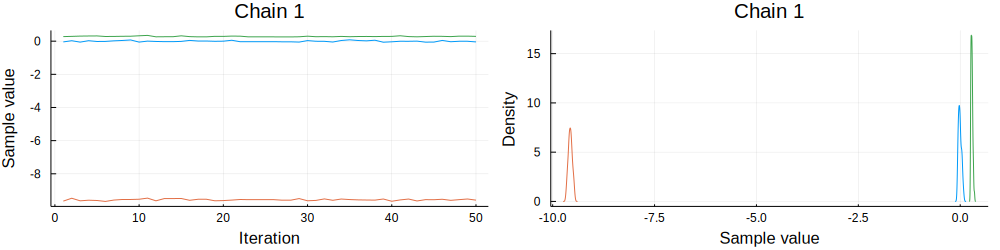

 25.485426 seconds (52.96 M allocations: 2.909 GiB, 5.51% gc time)


In [4]:
@model single_force(obj0, states, dt) = begin
    obj = obj0
    σ ~ InverseGamma(2, 3)
    f ~ MvNormal(zeros(2), 10)
    for t in 1:length(states)
        env = WithForce(Space(obj), 1 => f)
        obj = first(objectsof(transition(env, dt)))
        states[t] ~ MvNormal(vec(stateof(obj)), σ)
    end
end

@time chn = sample(single_force(data.obj0, data.states, args.dt), args.alg, args.n_samples)

splot(chn; colordim=:parameter) |> display

;

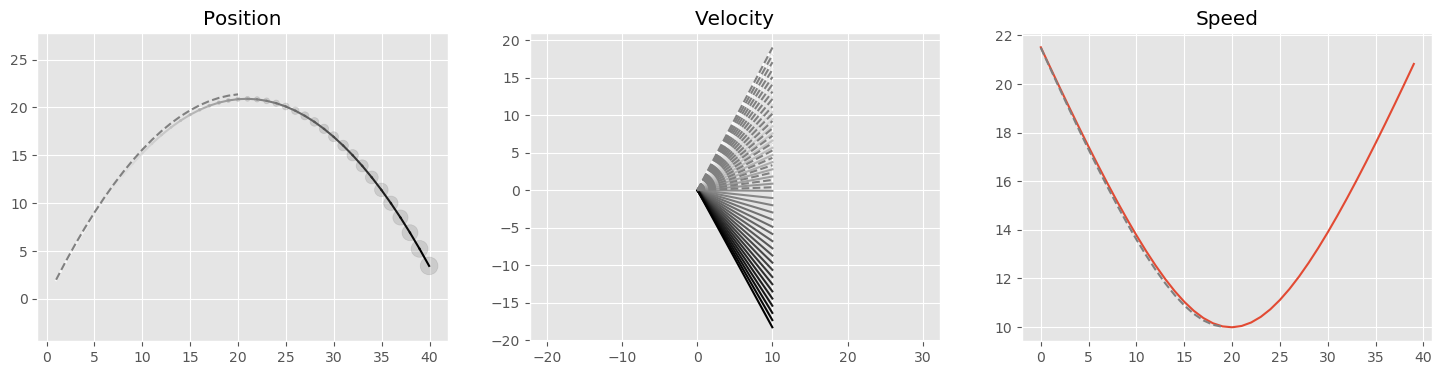

In [5]:
function meantraj(traj_list)
    pos = mean(t.pos for t in traj_list)
    vel = mean(t.vel for t in traj_list)
    return Particle.(1.0, pos, vel)
end

function stdtrajdev(traj_list)
    pos = mean(t.pos for t in traj_list)
    dev = []
    for t in 1:length(pos)
        ps = [traj_list[i].pos[t] for i in 1:length(traj_list)]
        push!(dev, 2 * sqrt(sum(std(ps).^2)))
    end
    return dev
end

function updatedev!(ax, traj_list)
    traj = meantraj(traj_list)
    dev = stdtrajdev(traj_list)
    for t in 1:length(traj)
        c = plt.Circle(tuple(positionof(traj[t])...), dev[t], color="gray", alpha=0.25)
        ax.add_artist(c)
    end
end

let n_mc = 20, res = get(chn[end-n_mc+1:end], [:f]), T = length(data.traj)
    traj_list = []
    for i in 1:n_mc
        f = [res.f[1][i], res.f[2][i]]
        traj = simulate(WithForce(Space(data.obj0), 1 => f), args.dt, 2T)
        push!(traj_list, (pos=positionof.(traj), vel=velocityof.(traj)))
    end
    fig, axes = plot(meantraj(traj_list), data.traj)
    updatedev!(first(axes), traj_list)
    display(fig)
end

;

## Single force and particle parameters

┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /Users/kai/.julia/packages/Turing/MoqTc/src/inference/hmc.jl:553


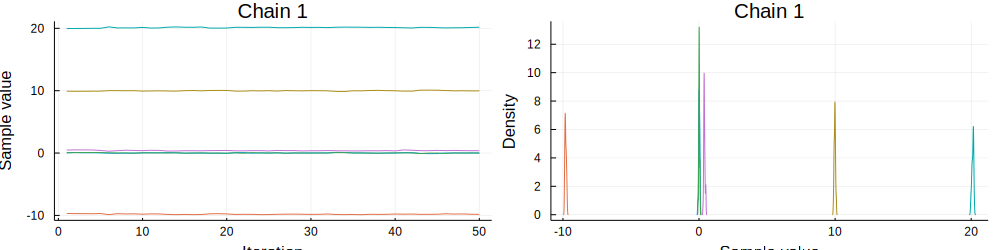

  6.735187 seconds (14.67 M allocations: 890.355 MiB, 3.82% gc time)


In [6]:
@model single_force_all_params(mass, states, dt) = begin
    f ~ MvNormal(zeros(2), 10)
    pos0 ~ MvNormal(zeros(2), 10)
    vel0 ~ MvNormal(zeros(2), 10)
    obj = Particle(mass, pos0, vel0)
    for t in 1:length(states)
        env = WithForce(Space(obj), 1 => f)
        obj = first(objectsof(transition(env, dt)))
        states[t] ~ MvNormal(vec(stateof(obj)), 0.1)
    end
end

@time chn = sample(single_force_all_params(massof(data.obj0), vec.(stateof.(data.traj)), args.dt), args.alg, args.n_samples)

splot(chn; colordim=:parameter) |> display

;

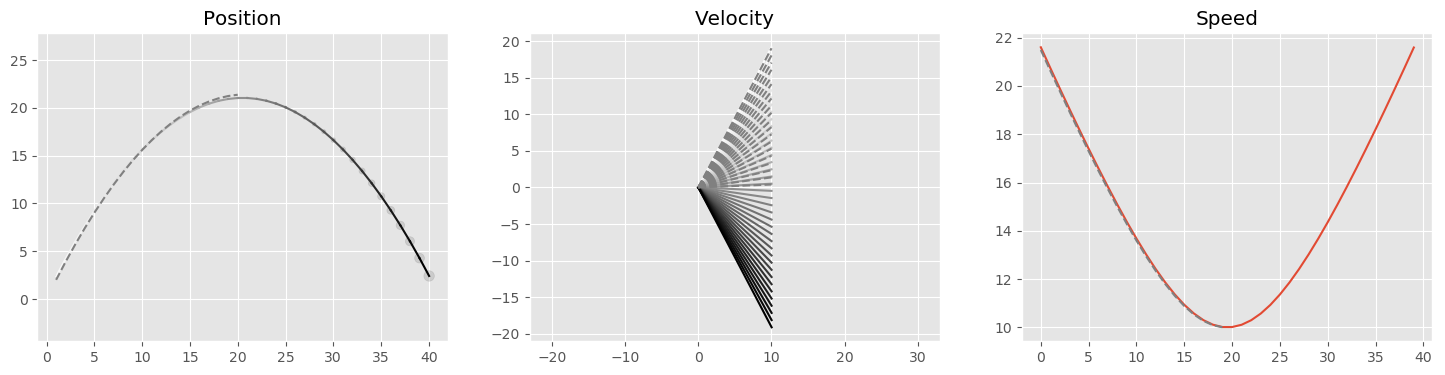

In [7]:
let n_mc = 20, res = get(chn[end-n_mc+1:end], [:f, :mass, :pos0, :vel0]), T = length(data.traj)
    mass = massof(data.obj0)
    traj_list = []
    for i in 1:n_mc
        f = [res.f[1][i], res.f[2][i]]
        pos0 = [res.pos0[1][i], res.pos0[2][i]]
        vel0 = [res.vel0[1][i], res.vel0[2][i]]
        env = WithForce(Space(Particle(mass, pos0, vel0)), 1 => f)
        traj = simulate(env, args.dt, 2T)
        push!(traj_list, (pos=positionof.(traj), vel=velocityof.(traj)))
    end
    fig, axes = plot(meantraj(traj_list), data.traj)
    updatedev!(first(axes), traj_list)
    display(fig)
end

;

In [8]:
data =
let obj0 = Particle(1.0, [0.0, 2.5], [2.5, 0.0]), T = 40,
    bars = [Bar([-5.0, 0.0], [5.0, 0.0]), Bar([5.5, 0.0], [5.5, 5.0])]
    env = WithStatic(Space(obj0), [EARTH, bars...])
    traj = simulate(env, PymunkSimulator(args.dt_fine), 2T)
    HTML(animof([env, traj...]; do_tracklocal=false).to_html5_video()) |> display
    (traj = traj[1:T], obj0 = obj0)
end

;

HTML{String}("<video width=\"500\" height=\"500\" controls autoplay loop>\n  <source type=\"video/mp4\" src=\"data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAAvom1kYXQAAAKhBgX//53cRem9\n5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENv\ncHlsZWZ0IDIwMDMtMjAxNyAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9w\ndGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1o\nZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2\nIGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0\nX3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE2IGxvb2thaGVhZF90aHJlYWRz\nPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9j\nb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0\nPTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWlu\ndD0yNTAga2V5aW50X21pbj0yMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2Fo\nZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9\nNjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAADlFliIQAN//+9vD+BTY7mNCX\nEc3onTMfvxW4ujQ3vc4AAAMAAAMADuPlocG+vHIc0AAAWwAGWbfzhDezFAQDc9v+/+M7+dqs2mru\nZEtYj21lXxBppZ9V1SKyQfkqn5f8smI/N8vxlVwKxEQw9G3tgb4kheD3FNi68Pxw3d0rvf80cwoS\nhgUEdsEEv+PoJ11oxd+5suQuVNGmeF+eCJOvsFhLEaE3BGj+b6Hf7ehP7Yj8p9RDMBbv57yOmm2j\nmrx7pfDZYoC1kHsgCOeZAprCdz+dzj6zNjNJQZADFJ2Wcdg06MBidbovu85/QlT/rea7+pzY8D2q\nGYEIr0L/VqOfDq8pjp2wwoZ2Hx6LnZyJHPp+hETiys4yf9IE9lewcYRz0LvXzl6XaxMLfT1r1Wv9\nDy7cpbwIbuZPS03Qy5JLMiFzZaUiF5QPBPuTuM2S2dOmFQJX5QB4E/+pQJk1hkrLVvGWNI1OZ+Yu\n4L0gocY4C67/RjRWKJlfkb5Za6E8nldK8wexNm8VQWjmfIv0h91zj+j8cUiVhcBsNeO+h5Gnco5c\ndTXm71nChGNBcFxKXVlmQHlkjERkQCA7QXtwNG2fzpNLXhNzI0pmgsUz3/iUBD/eRjCQAdrX2dvi\nY881xDt82Eqg0RvbbahjywA/j+pj778GmnvA4YG0egEc0Ha1JSAAAFoJOlGStgiWy+U1+7lXIxED\nDUKegU422XONU/V7aIlJPBJP+SF1ULpJnSeVsWBWaKIu7dsUMVlY2Kntx24iwxO1zvWSUNzAn7XK\nnHaVlgo+QoByDxMTxzQHdZDvuKADBWkGzUa/fdzPxZAyfj5jE5xzMsJIl0fQOsL61PW6JlE5MzVL\nqyBddk3GOHG5HJbQWiQroe/4lfuZMqottxJWjeTwToS8mfsgkMs7lIdO/EFxPqkf1YpUqzUzMTJB\nr8tYbnI9HKZMP5+rY5cXkb9MVd0F0sfTqG1QdSo45fkB13TJaJNKJlx94AvmqNCmGh7QKVN9AAAp\nwAb31EtVvYQi/yJNBldC+SUNHWfIy0rXnnKLrNpB5uQBdvzX0vYAtOvjpu9iIP4QwnKnYQyq6zym\n5Ne8EzK2987gyDaBWVUcvv2F1gaUer0D1wT5cEkxsHoyGGc2FZavJU4WHjMN6d1fVXyk2B0jbEPS\nK8bF/V3zeMj8WPib2/9nuPZZjSDS/UhmSUAsgf/TjD/+Dz7yyB2v97KSw1cWn/0wcUWfYFmjvlvF\nib2S+uKQJctjb90VdqdRnKZJ8UZLeYcIng4lKtYEbClbmCcIzOWS57D+aeNNFrkJUSfvN8sXNv9Y\nSYB3e2DfLVgE9m1biFqu8sHcz5jGlKYfFd1NoL4JSCZZ8J0OENp/ipCcr8P0jmF5VW4NH+TBBI/K\norBFc4fOIPLRMiDqgC60G6ltIXTvTSw/l1+XqQCDY/ncIZsRkgCMOgXPN4YXvbMcUO6OoUj+GLsJ\n8BJBjGXtZY4Uii5m5z8oMR74gTsAAHn//z/y3ZO9Dg5rKox1F3RtRVetdr9rQSsSCYzGeLvo/mOu\nbbzdUc92Ag7hTY3K8WqlgD7fSZV3odISryzIGfXXEMuqU67ZnKWnvddxcRN5T1AAKhedOksV9pC1\ndj6nDm7J3PSsZgZ619LMm1rZ022n1CX9RsuTZEoBDQU/BKJhP4t464T1q7F6OzFtDVZJ47BMnR4s\nXCRGfzUBXq708lGdcv/OhQX8dyEgphEIsl4RfPPZm7Gmg+wm4lhpxTC88euMZQM5HbtG4e6Aq7zT\nKHS9Z/ABomVFyX1WEh9VPXWHkWDcjvqQ2zQmw3qCXaFSCKGITNu+M/KzRMjPaiZBgMSSLbuAqwNm\nre0omzDbPurSCjnTNWOnjAordVX3gBVfUQn8GAOjWCp+CXSsFoAAG8jHhqdLQooAAAMAAJrB11pB\nnIb6cKhokpc2r6ErAKneANM2q902O8Ab8/CGfJWiBtYK5j+iWLqDYcamujnyXPkh1QyBS9cSy4/h\nG0du1biuffzl4f2iUqjQeHJo1bbMEGWCrKBMg+WRnV8DOWCQkuq2wB69vhyac90MajhHAZ1OmkgA\ngf9P5GY/nTUoSiT/P3+dB5kJx+sU15Vf1NSP49bCINj9wm62Jhzhf46smaXZJSdOf8qfgNHRFYC6\n33MnzQGJlueTBoeGUvORGsX2JC0rVe/81OaSREzD9Oo2yV/KJ10AABlhE7DPDXs4AAADAAR3Wc/b\nvXK7pM+Q2PhZ3z1Q+0HxOJ60REnHGnmGoDowugsQg7cNH/LXGPRJmCEvu2TTZ1OlJFmdSQ5nfNOA\npFdmf58Ooau4+n+b/iWWppqL2Zh4/+FmLVsNBdQ9YnIZlD0WyflOCtS5zPyw+eNZtVrc1C7bMsaJ\nObiZ5mAPfVn+LIKR+D0euQ6qMr4+mexHdCtZsQU2wStHKvWL21VBVLKhyoqvf+ipMewO7WNZicle\nFECX385+YbQqNGaaBNiAK56LHF/fAtJLIwX5lmTXKDJuP2VDuKAneYCYdcPGpAfC5aNIM0+DAXxg\nD9XfmKhScWQqVsi4jIQxuV6NfKzponLYlQPwnz4T1eHwUjH2iJX/qyv+8JYvNyEB6iYD58i5PQxQ\nGplVUMYwIgKKKZ8VRJXkrJb6aF24ALvTV7zfVDwOcbqszvlU/tFyO/qSNWS6++srbF/5GnndPAut\nxd7tdB5rOsZYt4nmXoAAABH5mOOpqgRyXbtRReDAr+BEW+93icPZ0yUBA7YKiCVHUS2yWmlteFxd\nu35CJGhkGzu+eavA06UN1XdtAQ7Fzg1a65MRtt4wGXf9VF

## Each force for each time step

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/kai/.julia/packages/Turing/MoqTc/src/inference/hmc.jl:553


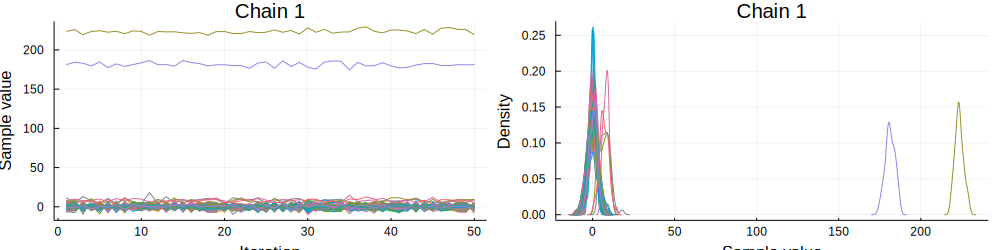

193.866780 seconds (1.86 G allocations: 167.186 GiB, 21.22% gc time)


In [9]:
@model multiple_forces(obj0, states, dt, ::Type{R}=Float64) where {R} = begin
    obj = obj0
    T = length(states)
    F = Vector{Vector{R}}(undef, T)
    for t in 1:T
        F[t] ~ MvNormal(zeros(2), 10)
        env = WithForce(WithStatic(Space(obj), EARTH), 1 => F[t])
        obj = first(objectsof(transition(env, dt)))
        states[t] ~ MvNormal(vec(stateof(obj)), 0.1)
    end
end

@time chn = sample(multiple_forces(data.obj0, vec.(stateof.(data.traj)), args.dt_fine), args.alg, args.n_samples)

splot(chn; colordim=:parameter) |> display

;

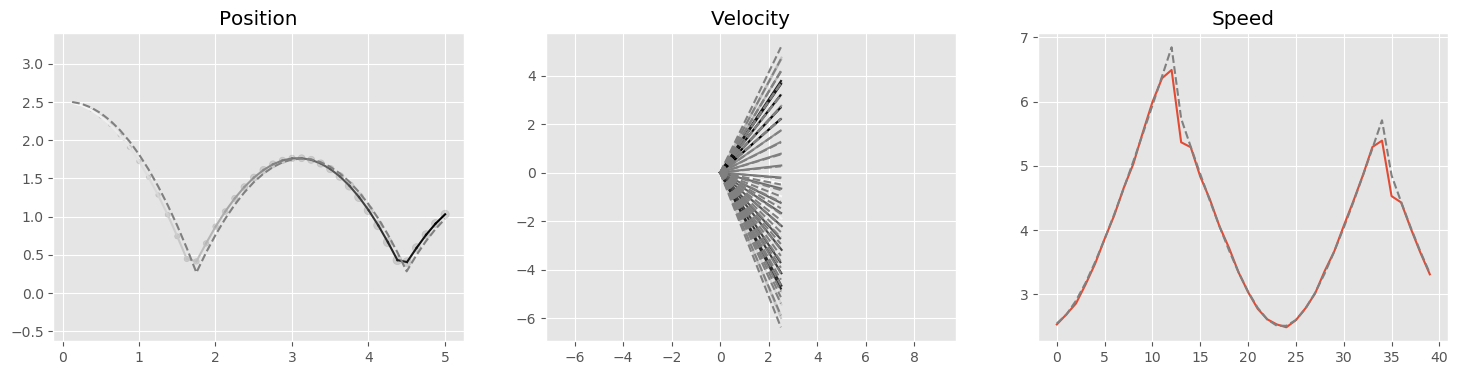

In [10]:
let n_mc = 20, T = length(data.traj)
    chn_sub = get(chn[end-n_mc+1:end], vec([Symbol("F[$t][$i]") for t in 1:T, i in 1:2]))
    traj_list = []
    for i in 1:n_mc
        obj = data.obj0
        traj = Vector{typeof(obj)}(undef, T)
        F = [[chn_sub[Symbol("F[$t][1]")][i], chn_sub[Symbol("F[$t][2]")][i]] for t in 1:T]
        for t in 1:T
            env = WithForce(WithStatic(Space(obj), EARTH), 1 => F[t])
            obj = first(objectsof(transition(env, args.dt_fine)))
            traj[t] = obj
        end
        push!(traj_list, (pos=positionof.(traj), vel=velocityof.(traj)))
    end
    fig, axes = plot(meantraj(traj_list), data.traj)
    updatedev!(first(axes), traj_list)
    display(fig)
end

;